In [1]:
import sys, os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import distribute as dist
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Add, Input, Bidirectional, Concatenate, ConvLSTM1D, Dense, Lambda, Normalization, MaxPooling1D, Activation, Dropout, Conv1D, Conv2D, BatchNormalization, Flatten, LSTM, Reshape
from tensorflow.keras.models import Model

import json
import util
import MDD_utils as utils
import time

2023-10-05 15:12:04.713254: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 15:12:05.082993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import set_memory_growth

physical_devices = list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    set_memory_growth(gpu_instance, True)

In [3]:
path = '../data/'  # database directory
training_set_name = 'wp_training.json'
test_set_name = 'wp_testing.json'

In [4]:
segment_size = 1024  # length of segments
segment_hop = 1024  # hop between segments
nseg = 8  # number of consecutive segments for LSTM

test_size = 0.2
epochs = 150
patience = 20
batch_size = 64

features = ['mag','segments','spectrum','timestamp_cuts','normalize_std','normalize_mean']

time_string = str(time.localtime().tm_mday) + '_' + str(time.localtime().tm_mon) + '_' + str(time.localtime().tm_year)
protocol_path = 'protocols/'
protocol_name = protocol_path + time_string + '_train_params.json'

protocol_name = utils.protocol(protocol_name,
                create=True, 
                               
                training_set_name=training_set_name,
                test_set_name=test_set_name,
                segment_size=segment_size, 
                segment_hop = segment_hop,
                nseg = nseg,
                test_size = test_size,
                epochs = 150,
                patience = 20,
                batch_size = 64,
                features = features
              )

In [5]:
data_dict = utils.load_datasets(path, training_set_name)

loading 04_04_22_Logs/log_S01__42_53_54_0B_A7_4A__20220404_1701.csv for Sham
loading 04_04_22_Logs/log_S02__42_53_54_0B_59_7B__20220404_1826.csv for Sham
loading 04_04_22_Logs/log_S03__42_53_54_0B_89_46__20220404_1717.csv for Sham
loading 04_04_22_Logs/log_S04__42_53_54_0B_AD_37__20220404_1739.csv for Sham
loading 04_04_22_Logs/log_P06__42_53_54_0B_52_46__20220404_1835.csv for PD
loading 05_04_22_Logs/log_P09__42_53_54_0B_65_3E__20220405_1844.csv for PD
loading 05_04_22_Logs/log_P12__42_53_54_0B_AD_37__20220405_1902.csv for PD
loading 05_04_22_Logs/log_P14__42_53_54_0B_59_7B__20220405_1919.csv for PD
loading 06_04_22_Logs/log_P15__42_53_54_0B_89_46__20220406_1754.csv for PD
loading 06_04_22_Logs/log_P16__42_53_54_0B_AD_37__20220406_1756.csv for PD
loading 06_04_22_Logs/log_P17__42_53_54_0B_A7_4A__20220406_1800.csv for PD


In [6]:
X, y = utils.feature_extraction(data_dict, segment_size=segment_size, segment_hop=segment_hop, nseg=nseg, feature = features)

In [7]:
X.shape

(14011, 8, 513)

In [8]:
def labels_and_test_split(X, y, test_size=0.2, random_state=42):
    # encode labels
    le = preprocessing.LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    y = to_categorical(y)
    n_classes = y.shape[1]
    labels = le.inverse_transform(np.arange(n_classes))

    # add dimension for LSTM (or convolution filters?)
    X = X[:,:,:,np.newaxis]

    # split into training/evaluation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('loaded {0:5.0f}/{1:<5.0f} training/validation examples'.format(X_train.shape[0], X_val.shape[0]))
    
    return X_train, X_val, y_train, y_val, n_classes, labels, le

In [9]:
X_train, X_val, y_train, y_val, n_classes, labels, le = labels_and_test_split(X, y, test_size)

print(X_train.shape)

normalizer = Normalization(axis=2)

loaded 11208/2803  training/validation examples
(11208, 8, 513, 1)


In [10]:
def cnn_lstm_model_1D(input_shape=(None, 257, 1)):
    
    def Slice(s):
        def func(x):
            return x[:,s,:,:]
        return func
    
    
    
    inputs = Input(shape = input_shape)
    x_norm = normalizer(inputs)
    
    #create shared layers
    conv_1 = Conv1D(8, 7, padding='same')
    conv_2 = Conv1D(16, 7, padding='same')
    conv_3 = Conv1D(32, 7, strides = 4)
    
    act_1 = Activation('relu')
    act_2 = Activation('relu')
    act_3 = Activation('relu')
    
    con_list = []
    for i in range(nseg):
        
        L = Lambda(Slice(i))(x_norm)
        
        temp = conv_1(L)
        temp = BatchNormalization()(temp)
        temp = act_1(temp)

        temp = conv_2(temp)
        temp = BatchNormalization()(temp)
        temp = MaxPooling1D(data_format='channels_last')(temp)
        temp = act_2(temp)
        
        temp = conv_3(temp)
        temp = BatchNormalization()(temp)
        temp = act_3(temp)

        con_list.append(temp)
        
    x = Concatenate(axis=1)(con_list)
    x = Dropout(0.5)(x)

    x = Reshape((8,int(x.shape[1]/8),32))(x)
    x = ConvLSTM1D(32, 8, return_sequences=True, dropout=0.5)(x)
    x = ConvLSTM1D(32, 8, dropout=0.5)(x)
    
    # old lstm layers
    #x = LSTM(64, dropout=0.5, return_sequences=True)(x)
    #x = LSTM(32, dropout=0.5)(x)
    
    x = Flatten()(x)
    
    # dense output layer, (softmax function in layer not recommended by tensorflow, maybe change?)
    x = Dense(n_classes, activation='softmax')(x) 
    
    return Model(inputs, x)

## Create and Compile the Model

`Strategy = dist.MirroredStrategy` and `Strategy.scope` is used for muli GPU training.

In [11]:
# Create a MirroredStrategy.
strategy = dist.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    
    model = cnn_lstm_model_1D(input_shape=(None, X.shape[2], 1))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2023-10-05 15:13:14.567855: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45231 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6
2023-10-05 15:13:14.570102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46702 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:d8:00.0, compute capability: 8.6


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape     

## Train the Model

In [12]:
normalizer.adapt(X_train)

es = EarlyStopping(monitor='val_accuracy', patience=patience)
mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/150
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.NCCL, num_packs = 1


2023-10-05 15:13:46.887350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 15:13:47.630810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-05 15:13:49.337028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 15:13:50.284927: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f31c23b1830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 15:13:50.285009: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-05 15:13:50.285026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-10-05 15:13:50.332765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:25

176/176 [==============================] - 72s 202ms/step - loss: 0.5464 - accuracy: 0.7114 - val_loss: 0.4566 - val_accuracy: 0.8016
Epoch 2/150
176/176 [==============================] - 32s 180ms/step - loss: 0.4000 - accuracy: 0.8149 - val_loss: 0.3083 - val_accuracy: 0.8733
Epoch 3/150
176/176 [==============================] - 31s 179ms/step - loss: 0.3526 - accuracy: 0.8459 - val_loss: 0.2556 - val_accuracy: 0.8926
Epoch 4/150
176/176 [==============================] - 31s 179ms/step - loss: 0.3035 - accuracy: 0.8680 - val_loss: 0.2568 - val_accuracy: 0.8965
Epoch 5/150
176/176 [==============================] - 31s 179ms/step - loss: 0.2758 - accuracy: 0.8832 - val_loss: 0.1890 - val_accuracy: 0.9204
Epoch 6/150
176/176 [==============================] - 31s 176ms/step - loss: 0.2422 - accuracy: 0.8974 - val_loss: 0.1846 - val_accuracy: 0.9204
Epoch 7/150
176/176 [==============================] - 31s 176ms/step - loss: 0.2198 - accuracy: 0.9085 - val_loss: 0.2279 - val_accurac

In [20]:
protocol_name = utils.protocol(protocol_name,
                               create=False,
                               accuracy=history.history['accuracy'],
                               val_accuracy=history.history['val_accuracy']
                              )

## Loss and Accuracy Plots

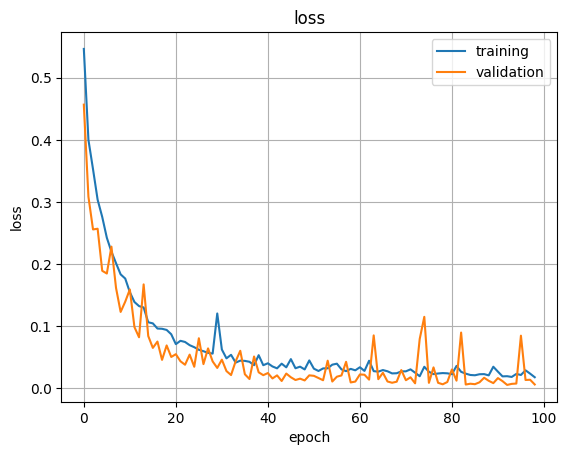

In [13]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.legend()
plt.grid()

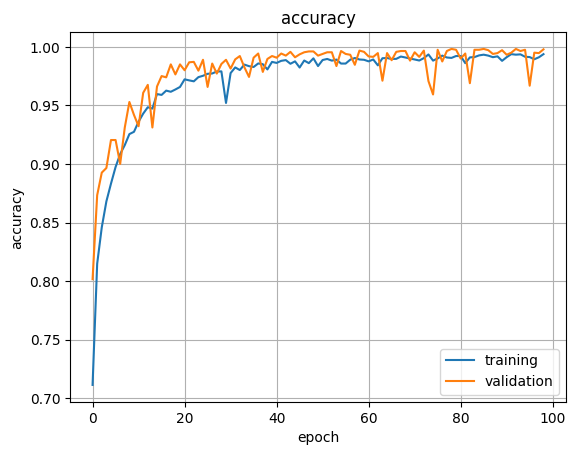

In [14]:
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')
plt.legend()
plt.grid()

## Predictions for split of Validation Dataset

In [15]:
# predict the classes for the test dataset
predictions = model.predict(X_val)
predictions = np.argmax(predictions, axis=1)

# derive the true classes from one-hot encoding
true = np.argmax(y_val, axis=1) 

# print the classification report
print(classification_report(true, predictions, target_names=labels))

88/88 [==============================] - 5s 34ms/step
              precision    recall  f1-score   support

          PD       1.00      1.00      1.00      1665
        Sham       1.00      1.00      1.00      1138

    accuracy                           1.00      2803
   macro avg       1.00      1.00      1.00      2803
weighted avg       1.00      1.00      1.00      2803



## Loading and Predicting Test Dataset

In [16]:
test_dict = utils.load_datasets(path, test_set_name)
X_test, y_test = utils.feature_extraction(test_dict, segment_size=segment_size, segment_hop=segment_hop, feature = features)#'spectrum',

y_test = le.transform(y_test)

# add dimension for LSTM
X_test = X_test[:,:,:,np.newaxis]

loading 04_04_22_Logs/log_S05__42_53_54_0B_65_3E__20220404_1753.csv for Sham
loading 05_04_22_Logs/log_P10__42_53_54_0B_52_46__20220405_1848.csv for PD
loading 05_04_22_Logs/log_P11__42_53_54_0B_89_46__20220405_1858.csv for PD
loading 04_04_22_Logs/log_P08__42_53_54_0B_37_57__20220404_1807.csv for PD
loading 05_04_22_Logs/log_P07__42_53_54_0B_47_57__20220405_1837.csv for PD
loading 06_04_22_Logs/log_P16__42_53_54_0B_AD_37__20220406_1756.csv for PD


228/228 [==============================] - 8s 33ms/step
              precision    recall  f1-score   support

          PD       0.83      0.78      0.80      5997
        Sham       0.19      0.24      0.21      1268

    accuracy                           0.69      7265
   macro avg       0.51      0.51      0.51      7265
weighted avg       0.72      0.69      0.70      7265



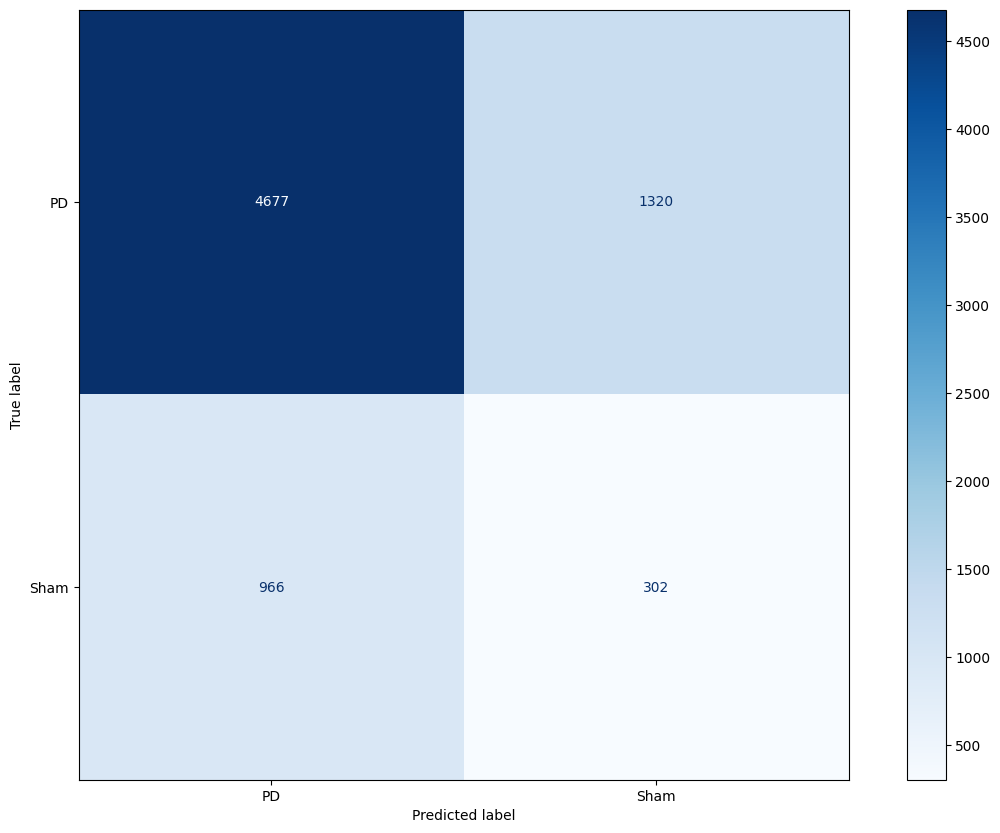

In [17]:
# predict the classes for the test dataset
predictions_test = model.predict(X_test)
predictions_test = np.argmax(predictions_test, axis=1)

# print the classification report
print(classification_report(y_test, predictions_test, target_names=labels))

# plot confusion matrix
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(y_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

## Create new Model and load Checkpoint

Create a new model and load the checkpoint with the best validation accuracy.

228/228 [==============================] - 7s 26ms/step
              precision    recall  f1-score   support

          PD       0.82      0.79      0.81      5997
        Sham       0.15      0.17      0.16      1268

    accuracy                           0.69      7265
   macro avg       0.48      0.48      0.48      7265
weighted avg       0.70      0.69      0.69      7265



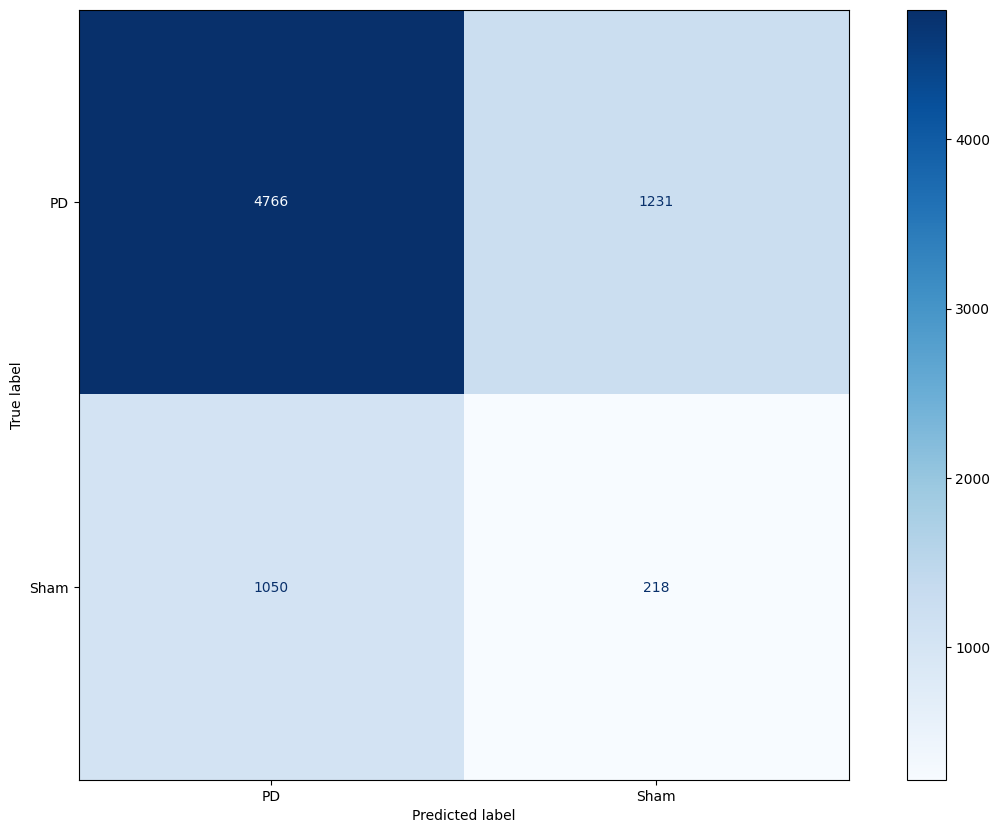

In [18]:
# Create a basic model instance
loaded_model = cnn_lstm_model_1D(input_shape=(None, X.shape[2], 1))

# Loads the weights
loaded_model.load_weights('best_model')

# predict the classes for the test dataset
predictions_loaded = loaded_model.predict(X_test)
predictions_loaded = np.argmax(predictions_loaded, axis=1)

# print the classification report
print(classification_report(y_test, predictions_loaded, target_names=labels))

# plot confusion matrix
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(y_test, predictions_loaded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()